# MrfmSim Overview

The notebook includes all the code examples on the overview page in the *mrfmsim* documentation. The notebook requires the *mrfmsim-marohn* package to be installed. For the detailed explanations of the experiments, see [mrfmsim-marohn documentation](https://github.com/Marohn-Group/mrfmsim-marohn-docs).

In [1]:
from mrfmsim.component import SphereMagnet, Grid, Sample, Cantilever


sample = Sample(
    spin="e",
    temperature=11.0,
    T1=1.3e-3,
    T2=0.45e-6,
    spin_density=0.5,
)
magnet = SphereMagnet(radius=3300.0, mu0_Ms=440.0, origin=[0, 0, 3300])
grid = Grid(shape=[400, 1200, 8], step=[25, 25, 25], origin=[0, 0, -100])
cantilever = Cantilever(k_c=7.8e5, f_c=4.975e6)

# define the input parameters
B1 = 1.3e-3  # transverse magnetic field
mw_x_0p = 100  # zero to peak amplitude of the cantilever motion [nm]
B0 = 500  # external field [mT]
f_rf = 19e9  # microwave frequency [Hz]
h = [0, 0, 1450]  # tip sample separation [nm]

## Graph representation and metadata

The experiment could be standalone or as a part of a collection.
In this example, ``IBMCyclic`` is a standalone experiment, and ``CermitESR`` is from the experiment collection ``CertmitESRCollection``. 

IBMCyclic(B0, df_fm, f_rf, grid, h, magnet, sample)
returns: (dF2_spin, dF_spin)
graph: ibm_cyclic_graph
handler: MemHandler
components:
- magnet: ['Bz_method', 'Bzx_method']
- sample: ['J', 'Gamma', 'spin_density', 'temperature']
- grid: ['grid_array', ['grid_voxel', 'voxel']]

Simulate an IBM-style cyclic-inversion magnetic resonance force microscope
experiment.
---------------
CermitESR
experiments: ['CermitESR', 'CermitESRStationaryTip', 'CermitESRSmallTip',
'CermitESRStationaryTipPulsed']
nodes: ['grid extended', 'Bz', 'Bz extended', 'B_tot', 'B_tot sliced', 'B_tot
extended', 'Bzxx', 'Bzxx trapz', 'mz_eq', 'B_offset', 'B_offset extended', 'x_0p
window pts', 'minimum absolute x offset', 'rel_dpol', 'rel_dpol periodic_irrad',
'spring constant shift', 'spring constant shift trapz', 'frequency shift']
settings:
- components: {'magnet': ['Bz_method', 'Bzx_method', 'Bzxx_method'], [...]

Simulates a Cornell-style frequency shift magnetic resonance force microscope
experiment in which mi

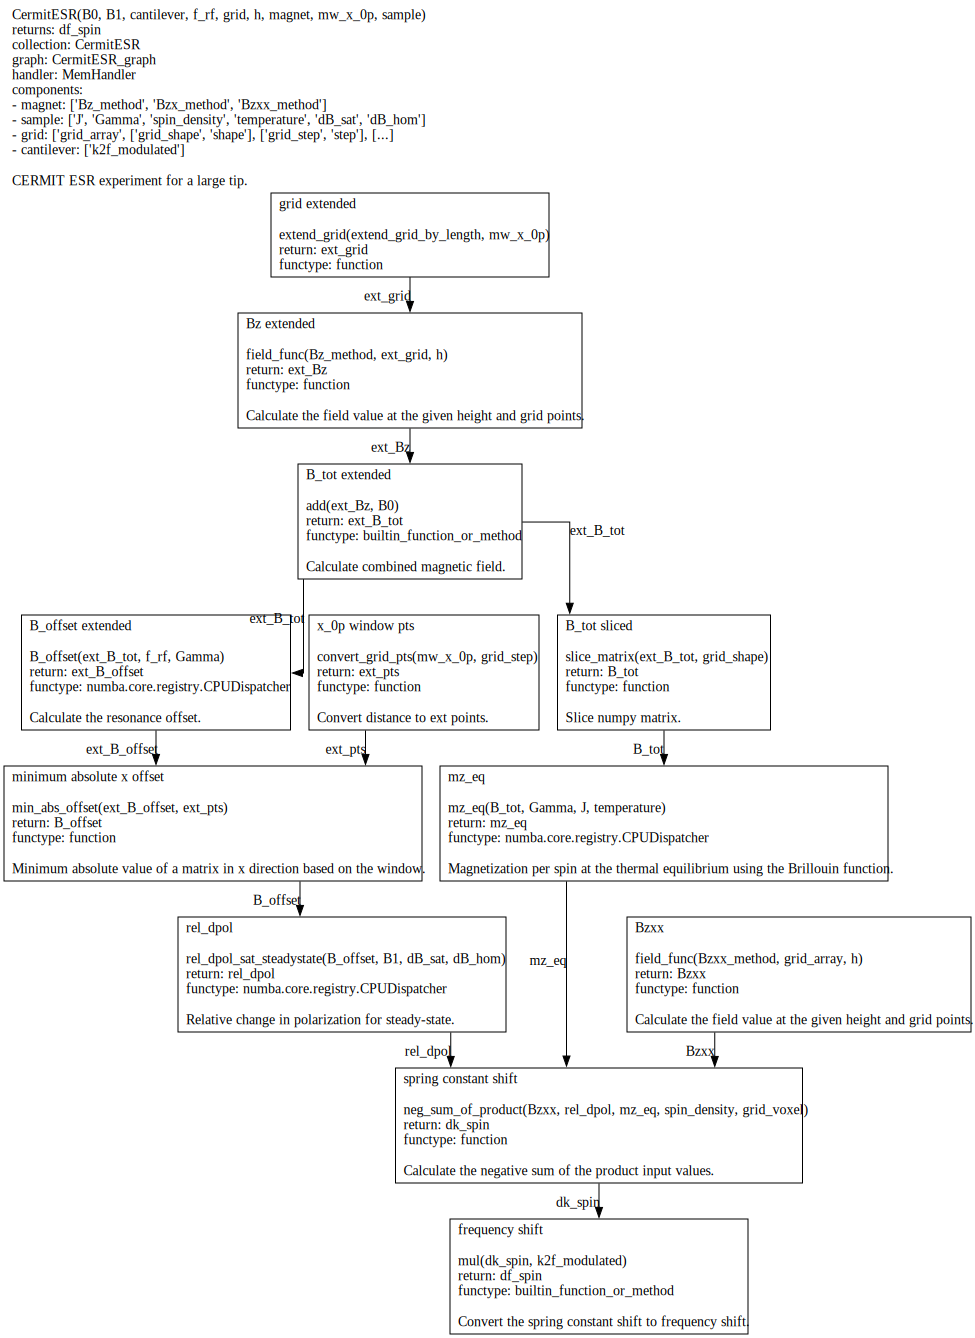

In [2]:
from mrfmsim.experiment import CermitESRCollection, IBMCyclic

# The standalone experiment is a model
print(IBMCyclic)

print('---------------')
# The collection summary
print(CermitESRCollection)

print('---------------')
# To list all the experiments in the collection
print(list(CermitESRCollection.experiments.keys()))

print('---------------')
# To access the CermitESR experiment model from the collection
CermitESR = CermitESRCollection['CermitESR']
print(CermitESR)

# To draw the experiment graph
CermitESR.visualize()

## Model Modification

### modify nodes - runtime profiling

We can easily profile the performance of the target nodes by
applying modifiers to the desired nodes. To edit individual nodes,
use the ``edit_node`` function from the model that returns a new
model.

In [3]:
from mrfmsim.modifier import profile_time

# get the original node modifiers
mods = CermitESR.get_node_object("rel_dpol").modifiers
CermitESR_profile = CermitESR.edit_node("rel_dpol", modifiers=mods + [profile_time(10)])
signal = CermitESR_profile(B0, B1, cantilever, f_rf, grid, h, magnet, mw_x_0p, sample)

rel_dpol_sat_steadystate - 10 loops, best of 1: 28.51 ms per loop


### modify returns - output intermediate values

To output intermediate values, we can directly change the returns.

In [4]:
CermitESR_intermediate = CermitESR.edit(returns=["f_rf", "dk_spin", "df_spin"])

# output three values in the order of f_rf, dk_spin, df_spin
CermitESR_intermediate(B0, B1, cantilever, f_rf, grid, h, magnet, mw_x_0p, sample)

(19000000000.0, -0.0024141111050284525, -0.0034656991967769407)

### modify model - optimal looping

For a complex model, we want to optimize the parameter loop so that only nodes that are dependent on the target parameter are looped. The looping can be adjusted at the node level using modifiers or adjusted at the model level using shortcuts.

Here we loop the applied frequency "f_rf" and the external field "B_0". 

Note that for individual parameters, the loop shortcut can achieve optimal looping. However, for multiple parameters, the users need to decide which parameter to loop first. Since all nodes that are dependent on "f_rf" also depend on "B_0", we loop "f_rf" first. 

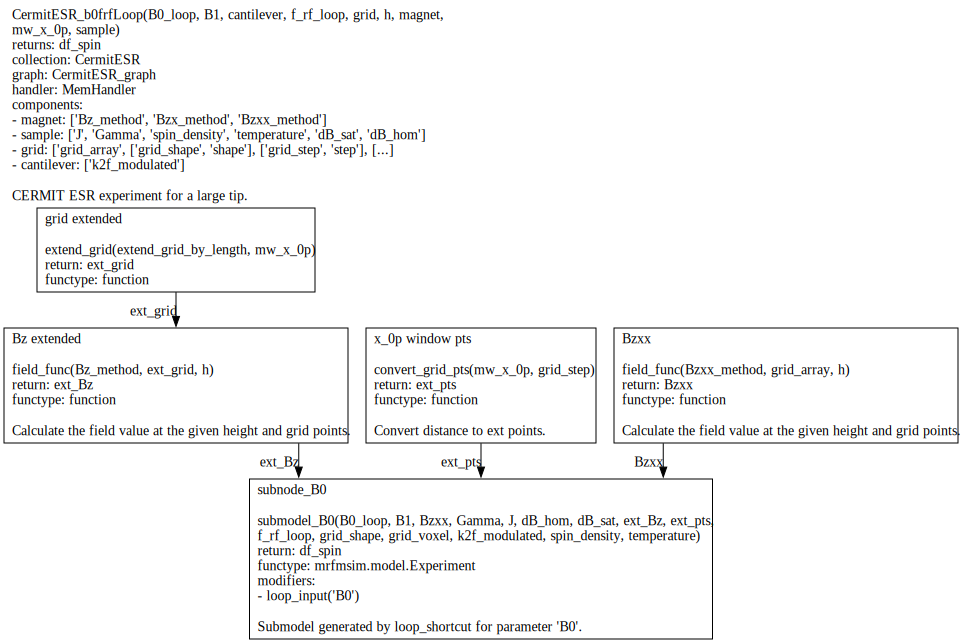

In [5]:
from mrfmsim.shortcut import loop_shortcut

# loop f_rf
CermitESR_frf_loop = loop_shortcut(CermitESR, "f_rf", name="CermitESR_frfLoop")
# loop B0
CermitESR_B0_frf_loop = loop_shortcut(
    CermitESR_frf_loop, "B0", name="CermitESR_b0frfLoop"
)

CermitESR_frf_loop.visualize()
CermitESR_B0_frf_loop.visualize()

The ``loop_shortcut`` changes the parameter name to ``{parameter}_loop`` to distinguish the iterable input from the original input type. For the 2 by 2 loop, the output is:

```
[[func(B0[0], f_rf[0]), func(B0[0], f_rf[1])],
 [func(B0[1], f_rf[0]), func(B0[1], f_rf[1])]]
```


In [6]:
import numpy as np

B0_list = np.arange(500, 900, 200)  # external field [mT]
f_rf_list = np.arange(18.5e9, 19.5e9, 0.5e9)  # microwave frequency [Hz]

# execute the model

CermitESR_B0_frf_loop(
    B0_loop=B0_list,
    B1=B1,
    cantilever=cantilever,
    f_rf_loop=f_rf_list,
    grid=grid,
    h=h,
    magnet=magnet,
    mw_x_0p=mw_x_0p,
    sample=sample,
)


[[-0.005362279436110155, -0.0034656991967769407],
 [0.0071300149234139135, 0.02300114588870745]]

### modify nodes - print out node input and output values

Sometimes we only want to inspect the intermediate value instead of adding them to returns. To achieve this, we can add print-related modifiers ``modifier.print_inputs`` and ``modifier.print_ouput`` to individual nodes. To simplify the process, the shortcut ``shortcut.print_shortcut`` can be used to automatically apply print statements to the nodes. The print format uses the keyword python format string. 

Here we show how to output the input "B0", "f_rf" and "df_spin" during the execution.

Note that the print shortcut only adds modifiers to individual nodes. They do not interfere with the looping modification.

In [7]:
from mrfmsim.shortcut import print_shortcut

print_model = print_shortcut(
    CermitESR, ["B0={B0:.2f} mT", "f_rf={f_rf:.2f} GHz", "df_spin={df_spin:.2e} Hz"]
)

signal = print_model(B0, B1, cantilever, f_rf, grid, h, magnet, mw_x_0p, sample)

B0=500.00 mT
f_rf=19000000000.00 GHz
df_spin=-3.47e-03 Hz
